In [19]:
# Install a pip package in the current Jupyter kernel
import subprocess
import sys
subprocess.call([sys.executable,"-m","pip","install","numpy","gspread","oauth2client","df2gspread","pandas","matplotlib","seaborn", "pandas-profiling"])


  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


0

In [20]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_string_dtype
import gspread
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
from itertools import chain
from oauth2client.service_account import ServiceAccountCredentials
import time
from collections import defaultdict
from pathlib import Path
from matplotlib.patches import ConnectionPatch

In [21]:
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 6000)
pd.set_option('display.width', 6000)
pd.options.display.max_colwidth = 0

In [22]:
data = pd.read_csv("../collected_data/raw_results.csv")

def get_column_full_name(keyword_on_column):
    full_names = []
    for column in data.columns:
        if keyword_on_column in column:
            full_names.append(column)
    
    if len(full_names) == 0:
        raise RuntimeError(f"Not found: '{keyword_on_column}'")
    elif len(full_names) > 1:
        raise RuntimeError(f"Found multiple column for: '{keyword_on_column}' {full_names}")
    
    return full_names[0]

for col in data.columns:
    print(col)

Carimbo de data/hora
Educational attainment
Area of study (e.g. Computer Science, Civil engineering)
Professional Experience in Software Development
Current role
Country
Rate your level of agreement with the following statements. [I have experience with tools that allow the creation of diagrams from terraform code  (e.g. terraform graph, pluralith, rover, inframap, others).]
Rate your level of agreement with the following statements. [I am familiar with the Unified Modeling Language (UML).]
Rate your level of agreement with the following statements. [I am familiar with UML component diagrams.]
Rate your level of agreement with the following statements. [I am familiar with UML deployment diagrams.]
I think that with Infragenie, it is easy to... [create architectural diagrams.]
I think that with Infragenie, it is easy to... [keep architectural diagrams updated.]
I think that with Infragenie, it is easy to... [keep architectural diagrams consistent with the source-code.]
I think that with

In [23]:
category_names = ['Strongly Disagree', 'Disagree',
                  'Neutral', 'Agree', 'Strongly Agree']

def generate_likert_graph(results, path, category_names=category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(12.5, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(True)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths

        ax.barh(labels, widths, left=starts, height=0.9,
                label=colname, color=color)
        xcenters = starts + widths / 2
        
        
        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)) + '%' if int(c) > 0 else '', ha='center', va='center',
                    color=text_color, fontsize='large', weight='demibold')
        
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, -0.2),
              loc='lower left', fontsize='large')
    plt.savefig(path, format='pdf', bbox_inches='tight')
    plt.show()
    return fig, ax

def likert_scale_order(level):
    level_sanitized = str(level).lower().title()
    if 'Strongly Disagree' == level_sanitized:
        return 1
    elif 'Disagree' == level_sanitized:
        return 2
    elif 'Neutral' == level_sanitized:
        return 3
    elif 'Agree' == level_sanitized:
        return 4
    elif 'Strongly Agree' == level_sanitized:
        return 5
    else:
        return 0

    
def get_likert_data_sorted(data):
    sample_size = len(data)
    occurrences = {'Strongly Disagree': 0, 'Disagree': 0, 'Neutral': 0, 'Agree': 0, 'Strongly Agree': 0} 
    
    for point in data:        
        if type(point) == str:
            point = point.lower().title()
            
            if point not in occurrences:
                raise RuntimeError(f"Invalid point '{point}' '{type(point)}")    
        
            occurrences[point.title()] = occurrences[point] + 1
    
    dist= {key: round((value / sample_size), 2) * 100 for key, value in occurrences.items()}
    return list(dist.values())


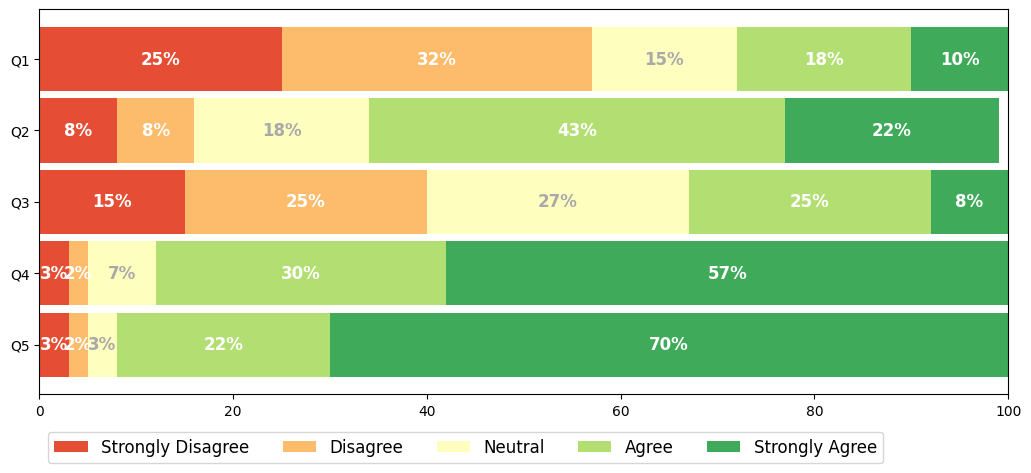

(<Figure size 1250x500 with 1 Axes>, <Axes: >)

In [24]:
# Familiariaty with UML/ terraform / visualization tools

columns = ['creation of diagrams from terraform code',
           'Unified Modeling Language',
           'deployment diagrams',
           'familiar with Terraform.',
           'familiar with the Terraform code in this repository',
           ]

results = {f"Q{i+1}": get_likert_data_sorted(data[get_column_full_name(item)]) for i,item in enumerate(columns)}

filepath = Path('../figures/uml_knowledge.pdf')
generate_likert_graph(results, filepath)

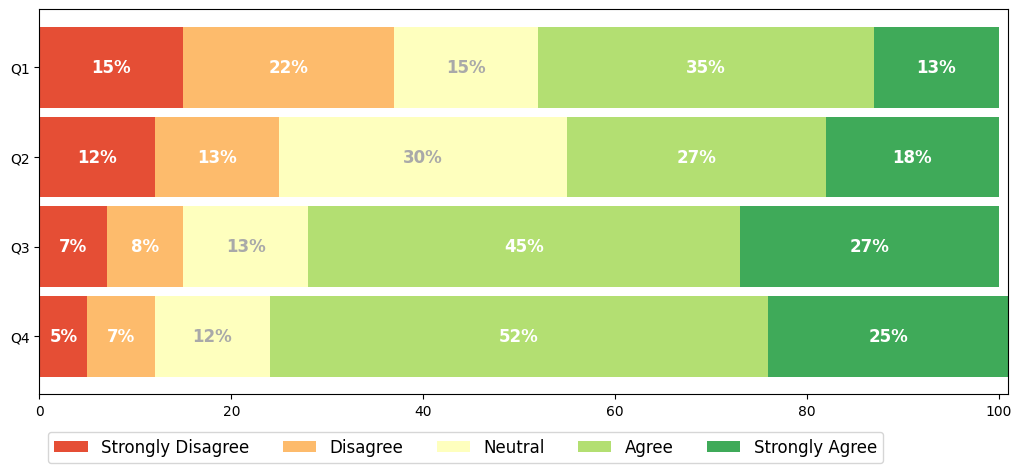

(<Figure size 1250x500 with 1 Axes>, <Axes: >)

In [25]:
# I think that the submitted architecture diagram is

columns = [
    'complete.',
    'precise.',
    'easy to understand.',
    'easy to read.'
    ]

results = {f"Q{i+1}": get_likert_data_sorted(data[get_column_full_name(item)]) for i,item in enumerate(columns)}


filepath = Path('../figures/terraform_software_architecture_extractor_usefulness.pdf')
generate_likert_graph(results, filepath)

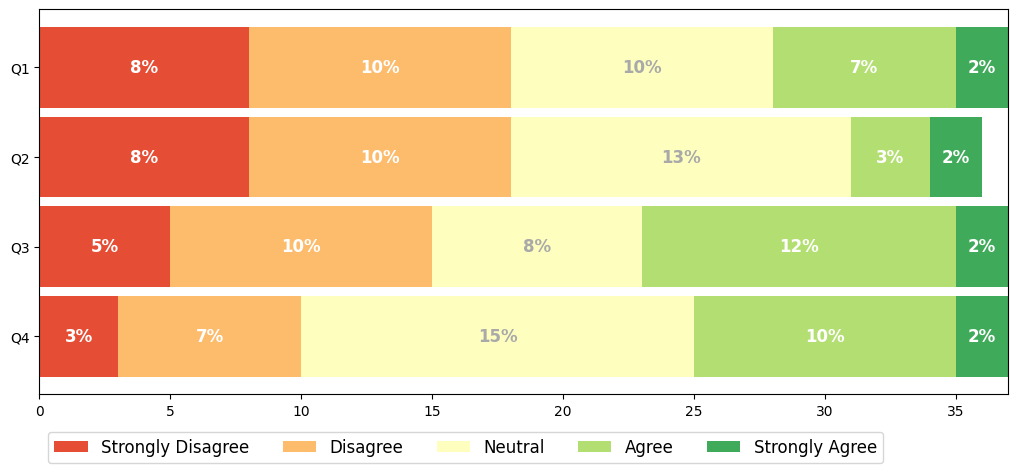

(<Figure size 1250x500 with 1 Axes>, <Axes: >)

In [26]:
# In comparison with existing diagrams,I think that the submitted architecture diagram is

columns = [
    'is more precise than the existing diagrams',
    'is more complete than the existing diagrams',
    'is easier to understand than the existing diagrams',
    'is easier to read than the existing diagrams'
    ]
columns_full_name = [get_column_full_name(i) for i in columns]

column_data = [data[c] for c in columns_full_name]
column_likert = [get_likert_data_sorted(d) for d in column_data]
results = {f"Q{i+1}": likert_data for i, likert_data in enumerate(column_likert)}


filepath = Path('../figures/terraform_software_architecture_extractor_comparison_with_existing_diagrams.pdf')
generate_likert_graph(results, filepath)

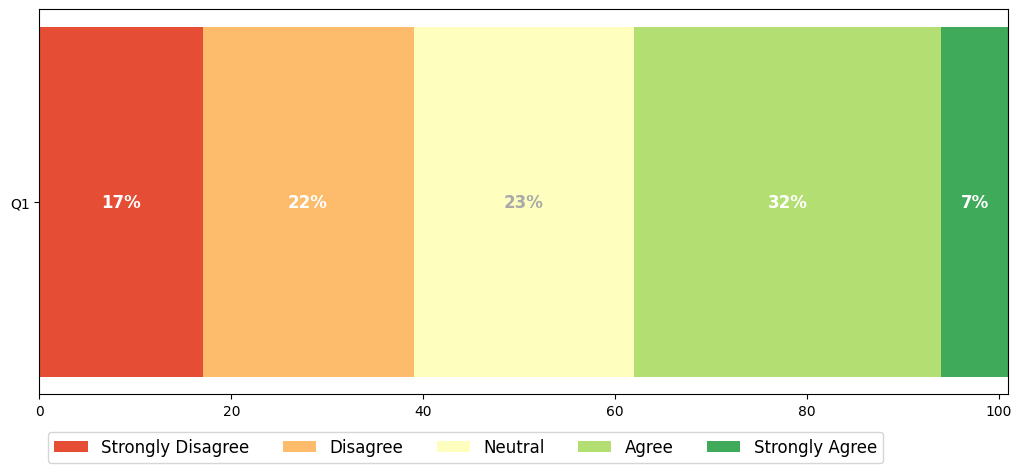

(<Figure size 1250x500 with 1 Axes>, <Axes: >)

In [27]:
# I am considering to include the generated architecture diagram to my project

columns = [
    'I am considering to include the generated architecture diagram to my project',
    ]

columns_full_name = [get_column_full_name(i) for i in columns]
column_data = [data[c] for c in columns_full_name]
column_likert = [get_likert_data_sorted(d) for d in column_data]

results = {f"Q{i+1}": likert_data for i, likert_data in enumerate(column_likert)}


filepath = Path('../figures/terraform_software_architecture_extractor_considering_to_use.pdf')
generate_likert_graph(results, filepath)